In [2]:
import os
import argparse
import torch
import numpy as np
from models import build_model
from utils import get_dataset, backdoor_train, backdoor_evaluate, validation_per_class
from poisoned_dataset import create_backdoor_data_loader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import time

In [3]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [4]:
class global_args():
    None
global_args()

In [5]:
class args():
    dir = '/home/teun/internship/cluster/results/optimalize'
    datanames = ['mnist', 'emnist', 'fmnist']
    seed = 1
    epsilon = 0.1
    source_labels = np.arange(10)
    target_labels = np.arange(10)
    epsilons=[0.001, 0.005, 0.010, 0.015, 0.020]
    iid = "True"

In [6]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
device = torch.device('cpu')

data_dir = '/home/teun/internship/sniper-backdoor/data'

In [9]:
# try:
#     backdoor_df = pd.read_csv('multiple_runs.csv')
# except:
for _ in range(1):
    results_dir = '/home/teun/internship/cluster/results/multiple_targets'
    datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
    results_dict = []
    for iid in tqdm([True, False]):
        for dataname in tqdm(datanames.keys(),leave=False):
            for epsilon in tqdm(args.epsilons,leave=False):
                for personalized in [True, False]:
                    for target in tqdm(args.target_labels,leave=False):
                        for source in tqdm(args.source_labels,leave=False):
                            if target==source:
                                continue
                            if personalized:
                                path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_finetuned_results.pt'
                                                    )
                            else:
                                path = path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_backdoor_results.pt')
                            model = torch.load(path, weights_only=False, map_location=device, )

                            clean_per_class = model['clean_per_class']
                            poisoned_per_class = model['poisoned_per_class']
                            asr = float(model['asr'])
                            cad = float(model['cad'])
                            if iid:
                                set_iid = 'IID'
                            else:
                                set_iid = 'Non-IID'

                            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'epsilon': epsilon, 'personalized': personalized,
                                                'clean_per_class': clean_per_class, 
                                                'poisoned_per_class': poisoned_per_class, 'asr': asr, 'cad': cad, 'target': target, 'source': source})      
    backdoor_df = pd.DataFrame(results_dict)
    backdoor_df.to_csv('multiple_runs.csv', index=False)  

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_18146/1559829924.py:10: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


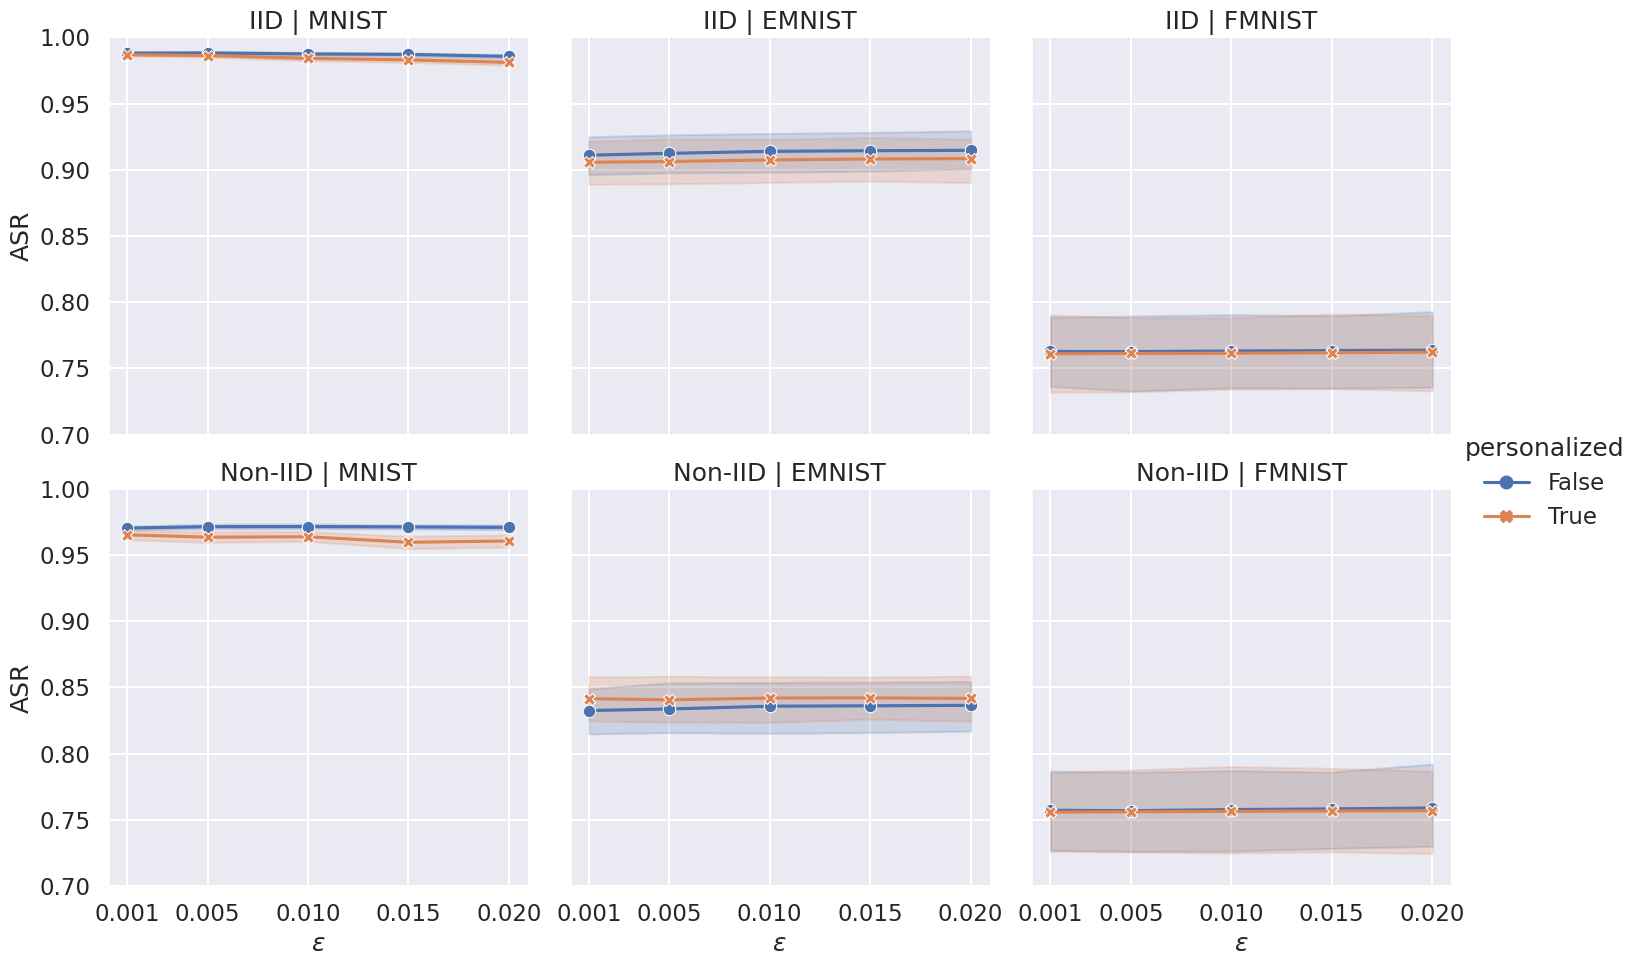

In [10]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='asr', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
plt.ylim([0.7, 1])
g.set_ylabels('ASR')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../asr.png')

In [18]:
sel = backdoor_df[(backdoor_df['dataname']=='MNIST') & (backdoor_df['epsilon']==0.001) & (backdoor_df['personalized']==True)]
sel.head(20)

,iid,dataname,epsilon,personalized,clean_per_class,poisoned_per_class,asr,cad,target,source
0,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9888), tensor(0.), tensor(0.9779), t...",0.990351,0.001575,0,1
1,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9898), tensor(0.9904), tensor(0.), t...",0.980806,0.001575,0,2
2,IID,MNIST,0.001,True,"[tensor(0.9877), tensor(0.9903), tensor(0.9779...","[tensor(0.9877), tensor(0.9895), tensor(0.9761...",0.978410,0.002916,0,3
3,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9898), tensor(0.9904), tensor(0.9779...",0.994872,0.001575,0,4
4,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9898), tensor(0.9904), tensor(0.9779...",0.985344,0.001575,0,5
5,IID,MNIST,0.001,True,"[tensor(0.9888), tensor(0.9921), tensor(0.9788...","[tensor(0.9908), tensor(0.9904), tensor(0.9798...",0.988577,0.002439,0,6
6,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9888), tensor(0.9904), tensor(0.9779...",0.983382,0.001575,0,7
7,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9929), tensor(0.9904), tensor(0.9779...",0.979592,0.001575,0,8
8,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.9908), tensor(0.9904), tensor(0.9779...",0.988922,0.001575,0,9
9,IID,MNIST,0.001,True,"[tensor(0.9878), tensor(0.9912), tensor(0.9789...","[tensor(0.), tensor(0.9904), tensor(0.9779), t...",0.988775,0.001575,1,0


In [21]:
backdoor_df['cad'] = backdoor_df['cad']*100

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_18146/2028972308.py:7: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


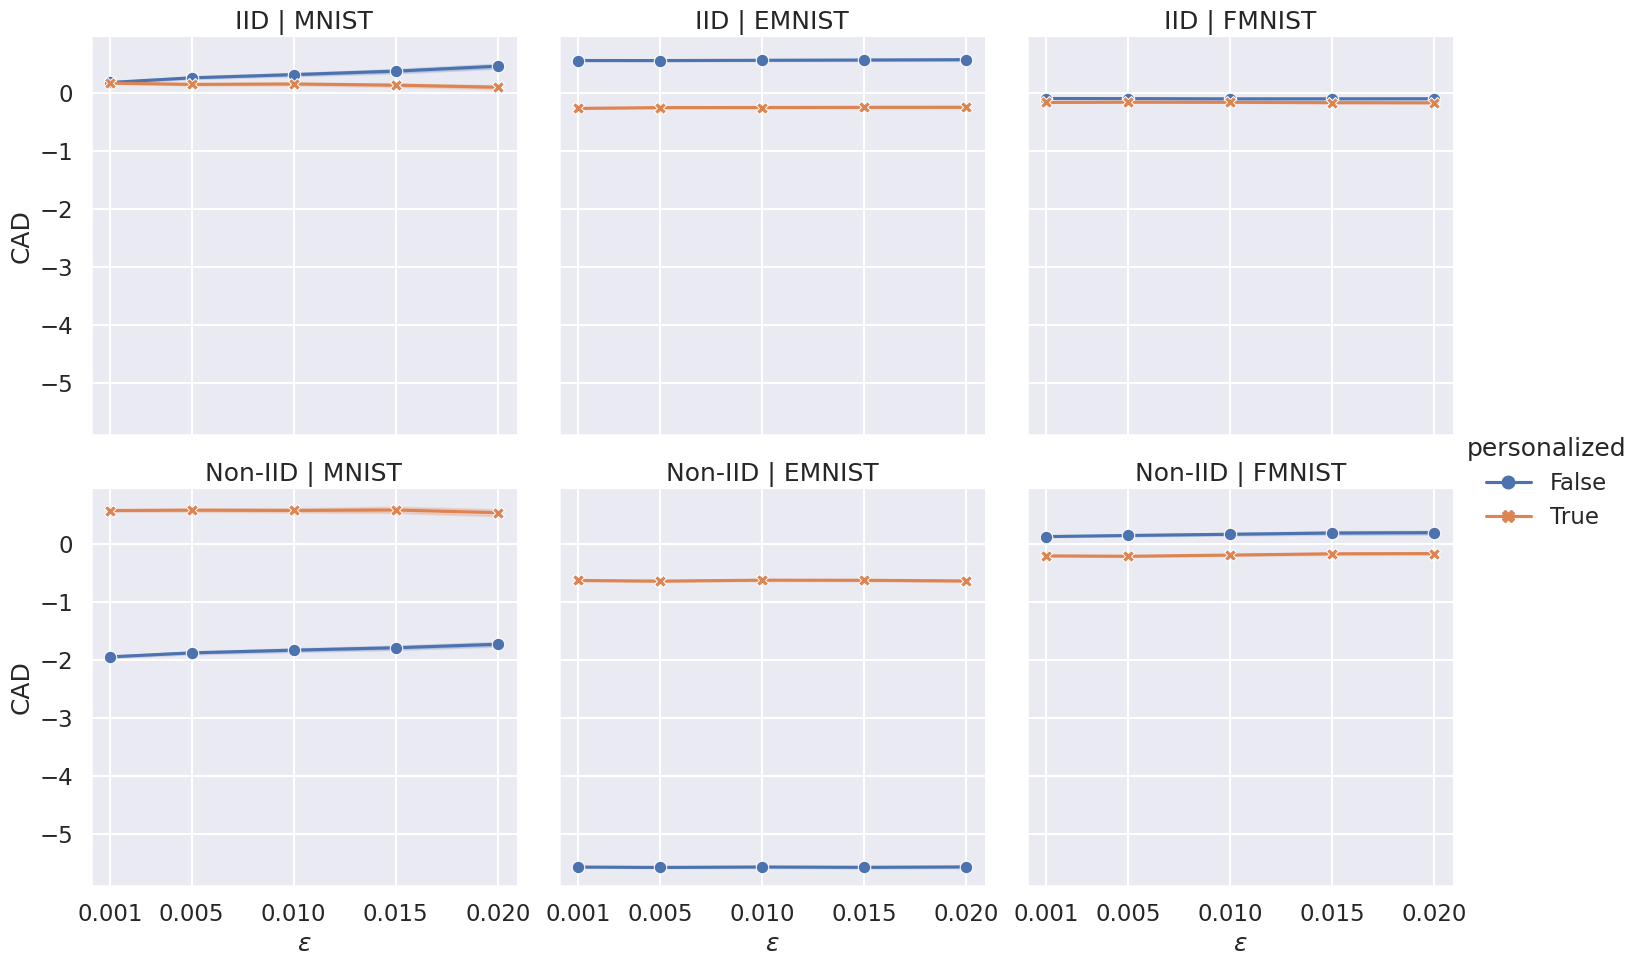

In [22]:
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='cad', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.001, 0.005, 0.010, 0.015, 0.020])
# plt.yticks(np.linspace(0.02,-0.06,5))
g.set_ylabels('CAD')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../cad.png')

In [46]:
# try:
#     backdoor_df = pd.read_csv('multiple_runs.csv')
# except:
args.target_labels = [1]
args.source_labels = [0]
args.epsilons=[0.050, 0.100, 0.200, 0.400, 0.800]
for _ in range(1):
    results_dir = '/home/teun/internship/cluster/results/mnist_eps'
    datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
    results_dict = []
    for iid in tqdm([True, False]):
        for dataname in tqdm(datanames.keys(),leave=False):
            for epsilon in tqdm(args.epsilons,leave=False):
                for personalized in [True, False]:
                    for target in tqdm(args.target_labels,leave=False):
                        for source in tqdm(args.source_labels,leave=False):
                            if target==source:
                                continue
                            if personalized:
                                path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_finetuned_results.pt'
                                                    )
                            else:
                                path = path = os.path.join(
                                                results_dir, 
                                                f'{dataname}_{epsilon}_{source}->{target}'
                                                f'_iid_{iid}_backdoor_results.pt')
                            model = torch.load(path, weights_only=False, map_location=device, )

                            clean_per_class = model['clean_per_class']
                            poisoned_per_class = model['poisoned_per_class']
                            asr = float(model['asr'])
                            cad = float(model['cad'])
                            if iid:
                                set_iid = 'IID'
                            else:
                                set_iid = 'Non-IID'

                            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'epsilon': epsilon, 'personalized': personalized,
                                                'clean_per_class': clean_per_class, 
                                                'poisoned_per_class': poisoned_per_class, 'asr': asr, 'cad': cad, 'target': target, 'source': source})      
    backdoor_df = pd.DataFrame(results_dict)
    backdoor_df.to_csv('extreme_eps.csv', index=False)  

<>:10: SyntaxWarning: invalid escape sequence '\e'
<>:10: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_18146/3834643180.py:10: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


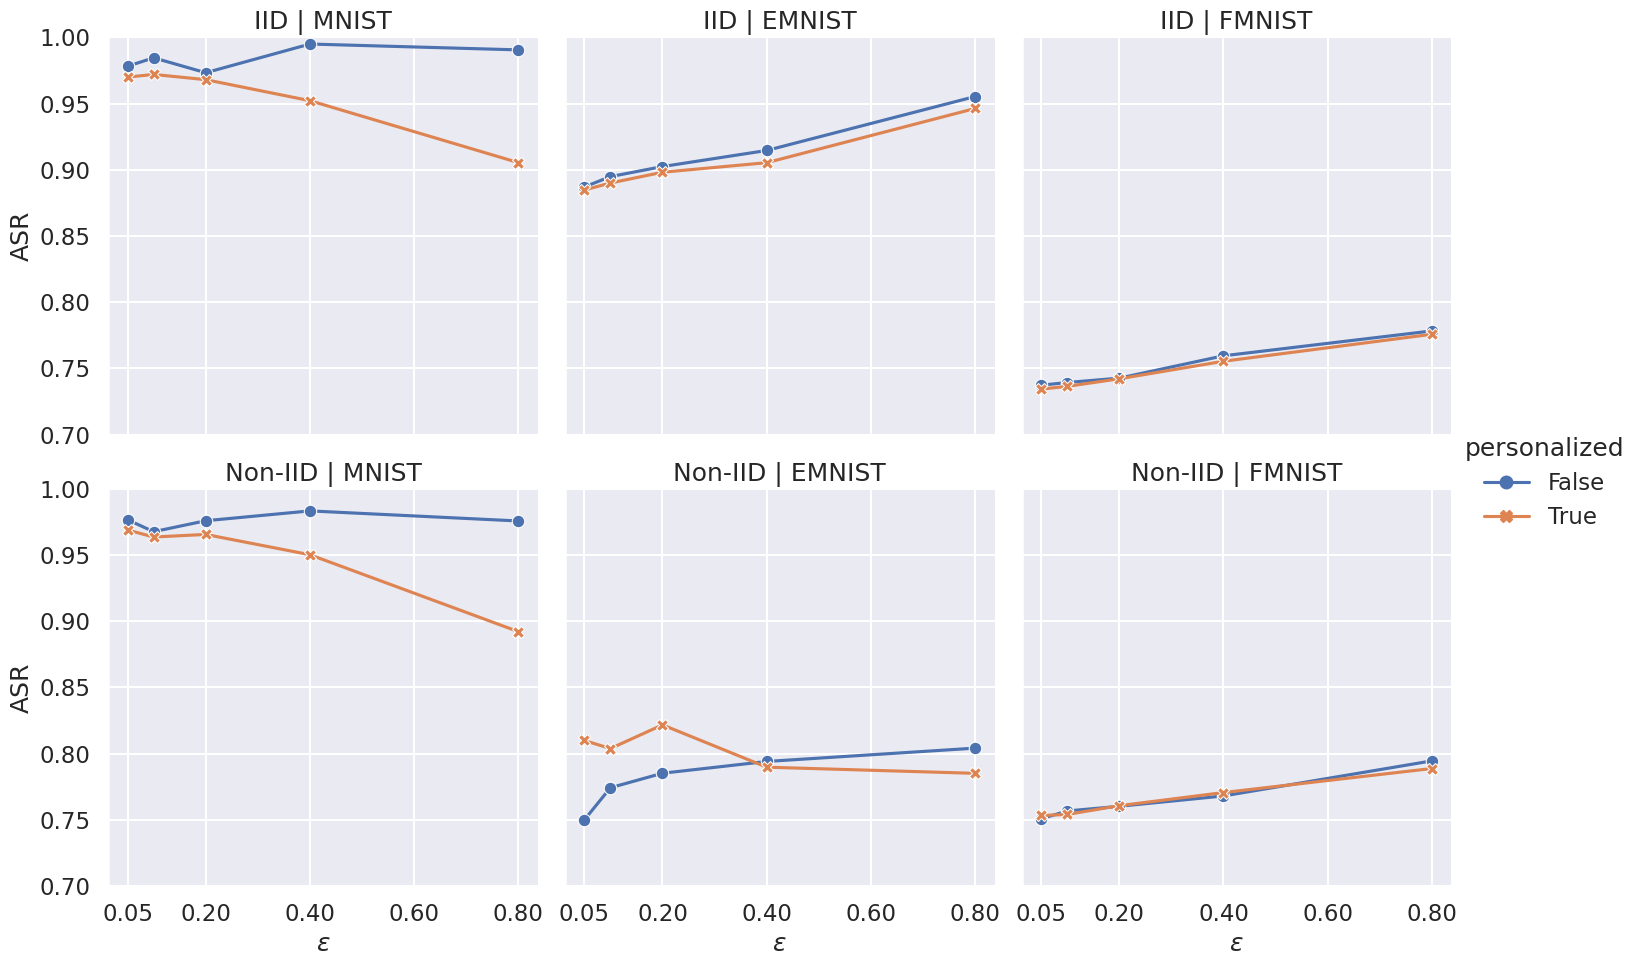

In [52]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='asr', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.050, 0.200, 0.400, 0.600, 0.800])
plt.ylim([0.7, 1])
g.set_ylabels('ASR')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../asr_eps.png')

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_18146/1772670008.py:7: SyntaxWarning: invalid escape sequence '\e'
  g.set_xlabels('$\epsilon$')


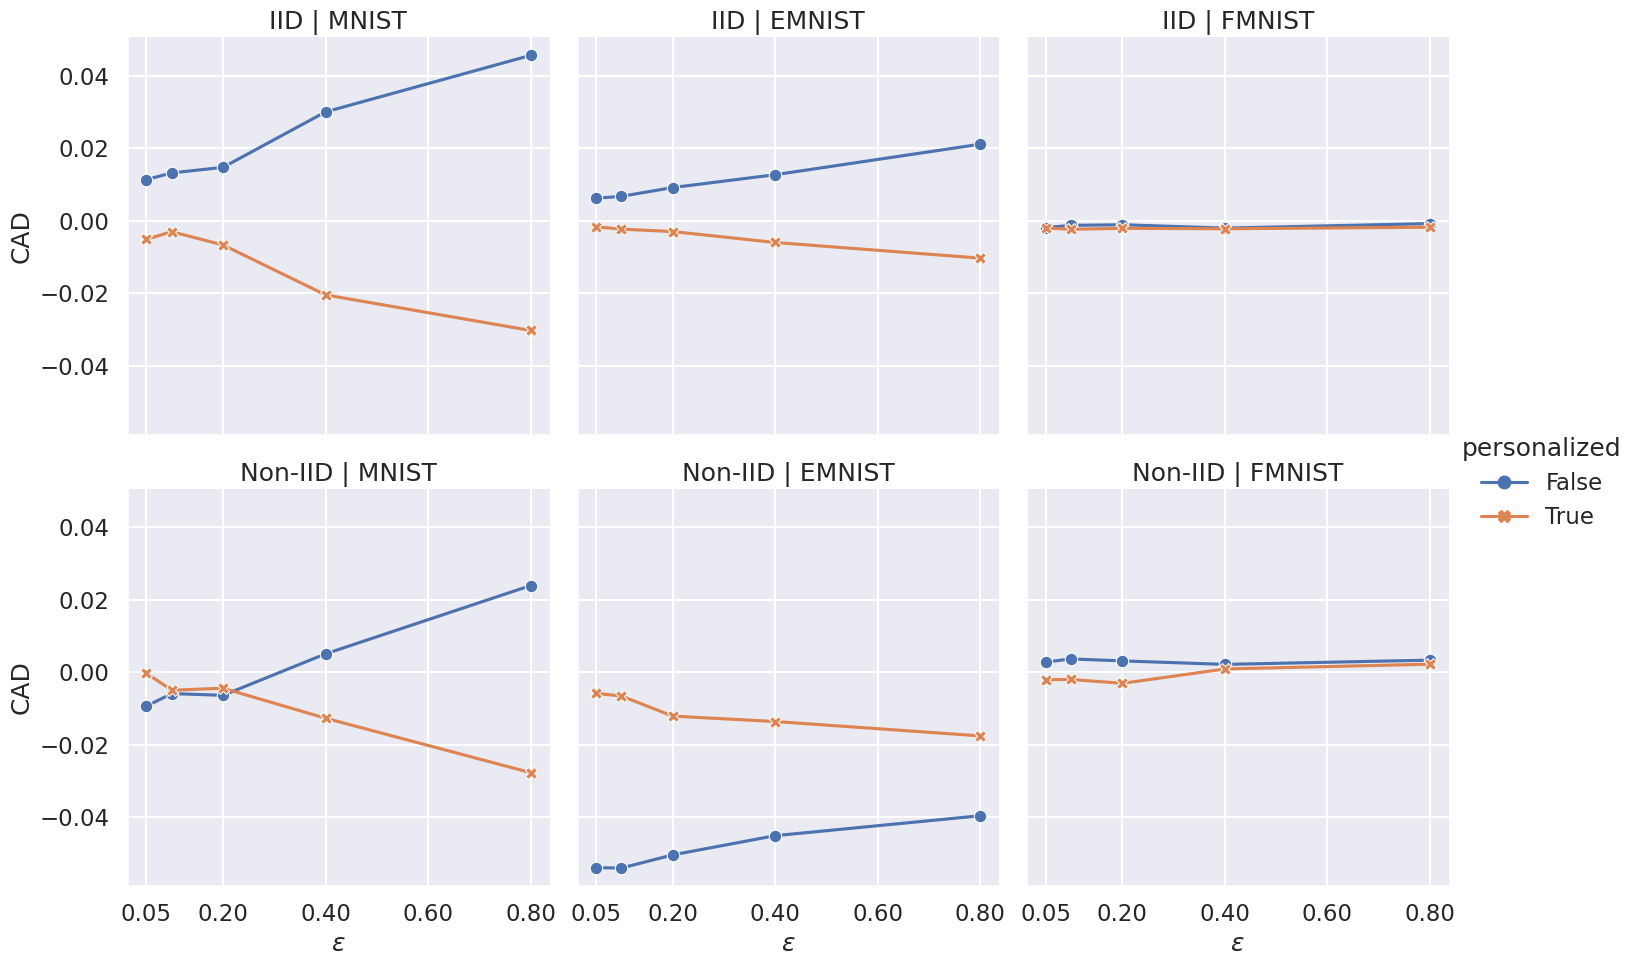

In [54]:
g = sns.relplot(data=backdoor_df, kind='line',
            x='epsilon', y='cad', hue='personalized', style='personalized', col='dataname', row='iid',
            dashes=False, markers=True)
plt.xticks([0.050, 0.2, 0.4, 0.6, 0.8])
# plt.yticks(np.linspace(0.02,-0.06,5))
g.set_ylabels('CAD')
g.set_xlabels('$\epsilon$')
g.set_titles(col_template='{col_name}', row_template='{row_name}')
g.savefig('../cad_eps.png')

In [23]:
results_dir = '/home/teun/internship/cluster/results/optimalize'
datanames = {'mnist': 5, 'emnist': 13, 'fmnist': 5}
results_dict = []
for iid in tqdm([True, False]):
    for dataname in tqdm(datanames.keys(),leave=False):
        for client in tqdm(range(datanames[dataname]),leave=False):

            path = os.path.join(
                results_dir, f'{dataname}_iid_{iid}_client_{client}_results.pt')
            server_model = torch.load(path, weights_only=False, map_location=device)

            train_loss = server_model['train_loss']
            train_acc = server_model['train_acc']
            test_loss = server_model['test_loss']
            test_acc = server_model['test_acc']
            train_epochs = np.arange(len(train_loss))
            test_epochs = np.linspace(1,len(train_epochs)-1,len(test_loss))
            if iid:
                set_iid = 'IID'
            else:
                set_iid = 'Non-IID'
            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': client, 'mode': 'train',
                                 'loss': train_loss, 'acc': train_acc, 'epochs': train_epochs})
            results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': client, 'mode': 'test',
                                 'loss': test_loss, 'acc': test_acc, 'epochs': test_epochs})
            
        path = os.path.join(
            results_dir, f'{dataname}_iid_{iid}_server_results.pt')
        server_model = torch.load(path, weights_only=False, map_location=device)

        test_loss = server_model['loss']
        test_acc = server_model['acc']

        results_dict.append({'iid': set_iid, 'dataname': dataname.upper(), 'client': None, 'mode': 'test',
                             'loss': test_loss, 'acc': test_acc, 'epochs': np.arange(len(test_loss))})

        

In [24]:
df = pd.DataFrame(results_dict)
df = df.explode(['loss', 'acc', 'epochs'], ignore_index=True)
df['loss'] = df['loss'].astype(float)

In [25]:
train = df[df['mode']=='train']
server = df[(df['client'].isna()) & (df['mode']=='test')]

In [26]:
train.head()

,iid,dataname,client,mode,loss,acc,epochs
0,IID,MNIST,0.0,train,1.685120,80.413793,0
1,IID,MNIST,0.0,train,0.280357,92.060345,1
2,IID,MNIST,0.0,train,0.164103,95.215517,2
3,IID,MNIST,0.0,train,0.125554,96.353448,3
4,IID,MNIST,0.0,train,0.105571,96.991379,4


In [ ]:
sel = train[train['client']==0]

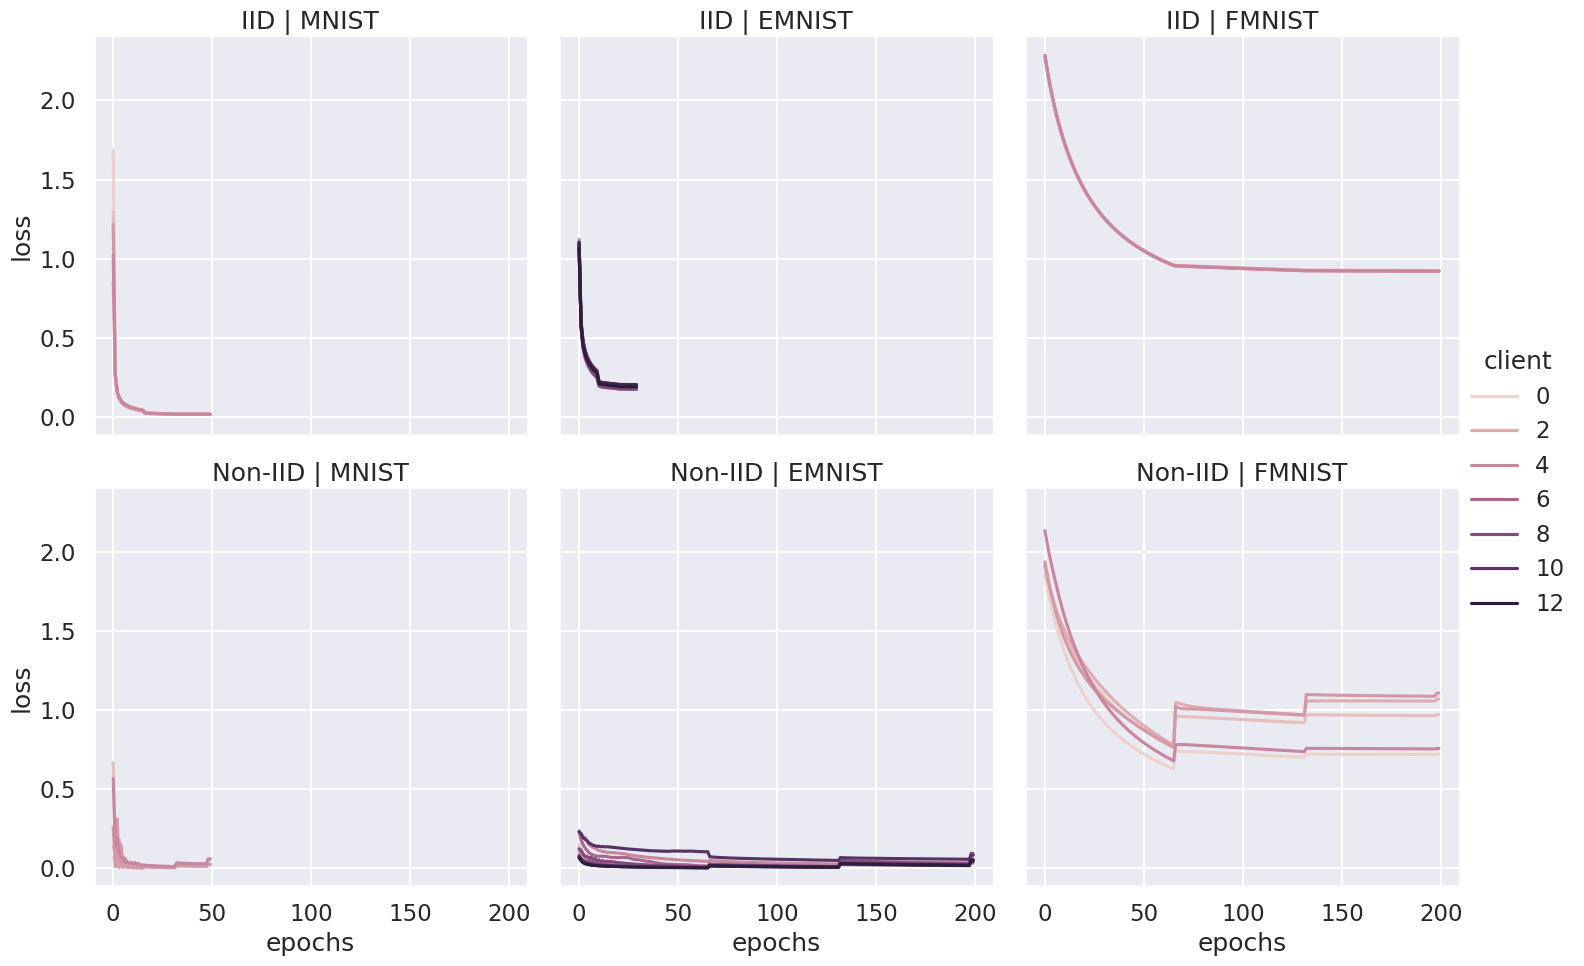

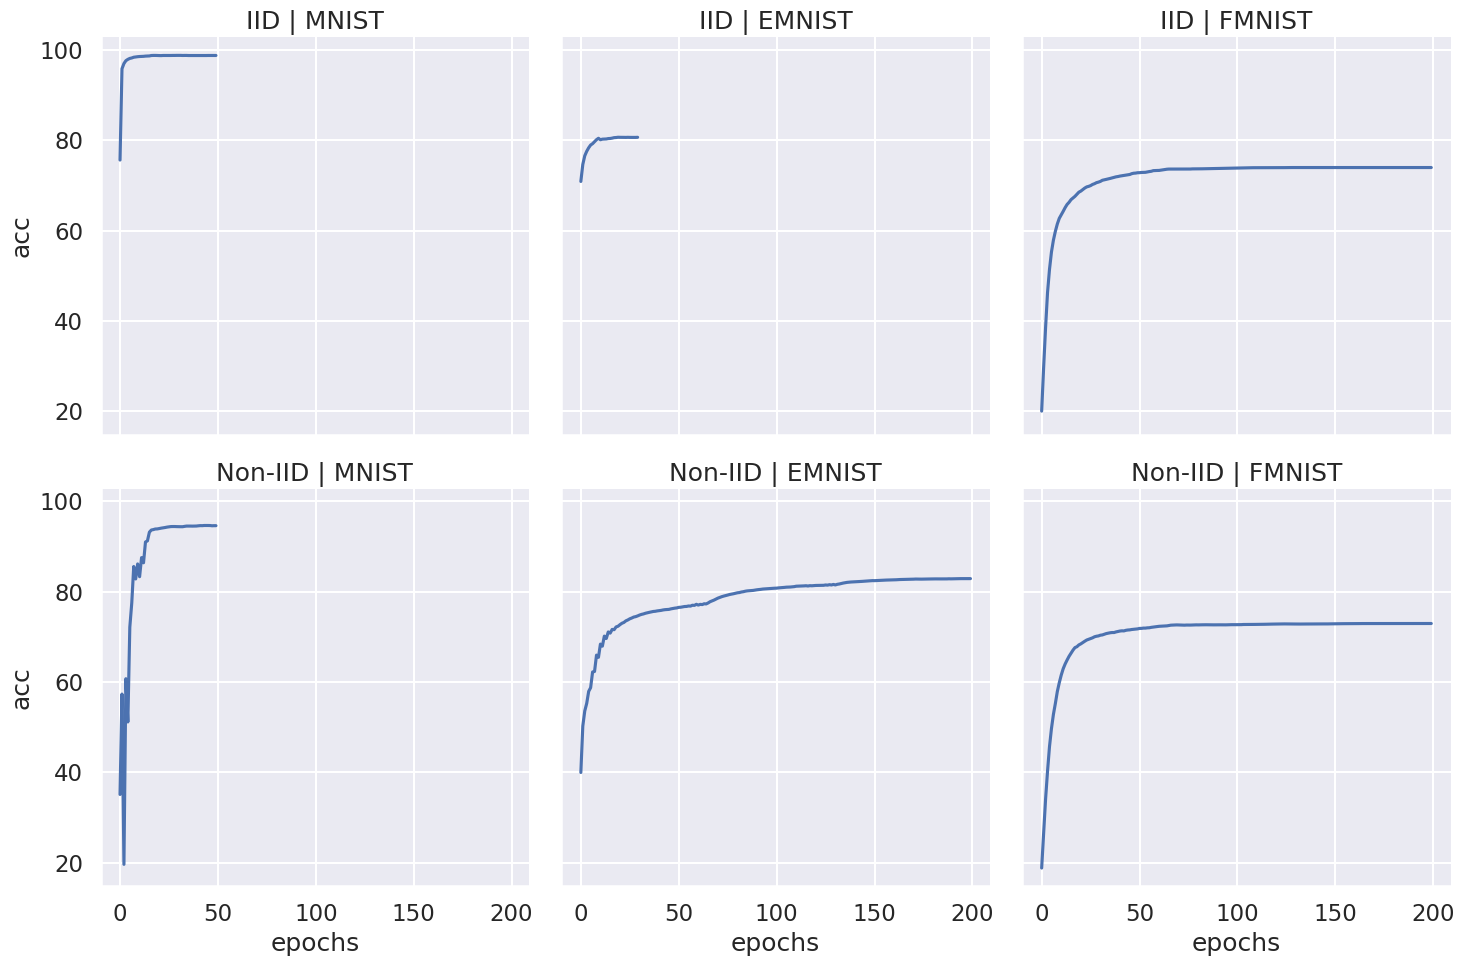

In [28]:
sns.set_theme(style='darkgrid')
sns.color_palette('colorblind')
sns.set_context('talk')
loss_plot = sns.relplot(
    data=train,
    x='epochs', y='loss', col='dataname', row='iid', hue='client',
    kind='line'
)
acc_plot = sns.relplot(
    data=server,
    x='epochs', y='acc', col='dataname', row='iid',
    kind='line'
)
for p in [loss_plot, acc_plot]:
    p.set_titles(col_template='{col_name}', row_template='{row_name}')
loss_plot.savefig('../train_loss.png')
acc_plot.savefig('../test_acc.png')

In [44]:
sel = train[(train['dataname']=='MNIST') & (train['client']==2) & (train['iid']=='Non-IID')]
sel.head(50)

,iid,dataname,client,mode,loss,acc,epochs
3760,Non-IID,MNIST,2.0,train,0.136916,98.172971,0
3761,Non-IID,MNIST,2.0,train,0.099462,98.264781,1
3762,Non-IID,MNIST,2.0,train,0.023387,99.283878,2
3763,Non-IID,MNIST,2.0,train,0.182004,97.631289,3
3764,Non-IID,MNIST,2.0,train,0.023754,99.164524,4
3765,Non-IID,MNIST,2.0,train,0.032482,98.916636,5
3766,Non-IID,MNIST,2.0,train,0.017514,99.430775,6
3767,Non-IID,MNIST,2.0,train,0.015984,99.504223,7
3768,Non-IID,MNIST,2.0,train,0.017125,99.412413,8
3769,Non-IID,MNIST,2.0,train,0.009911,99.761293,9
